# Упражнение 1

В данном упражнении на датасете Breast cancer wisconsin следует продемонстрировать работу моделей градиентного бустинга, xgboost, lightgbm и catboost.

Импортируйте необходимые библиотеки указанные в лекции.


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import catboost
import xgboost
import lightgbm

from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


Загрузите датасет. Разделите датасет на тестовую и обучающую выборки

In [5]:
cancer = datasets.load_breast_cancer()
X, y = cancer.data, cancer.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

Определите параметры

In [6]:
params = {'n_estimators': 100,
          'max_depth': 2,
          'min_samples_split': 6,
          'learning_rate': 0.01,
          'loss': 'ls'}

Обучите модель градиентного бустинга

In [7]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 0.0669


The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.


Постройте график качества обучения

Text(0.5, 1.0, 'Зависимость лосса от итерации')

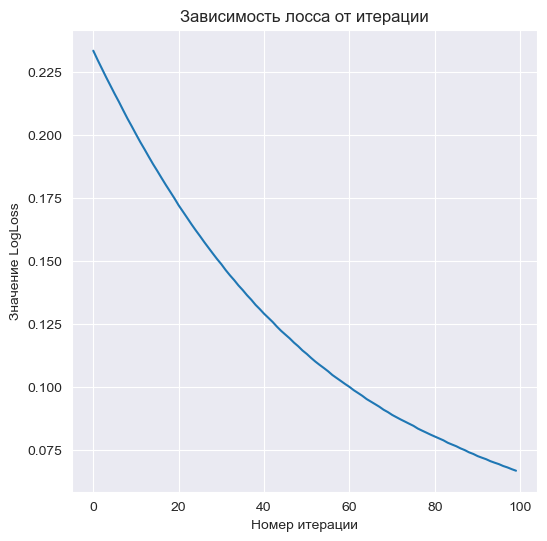

In [8]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.plot(np.arange(len(test_score)), test_score)
plt.xlabel('Номер итерации')
plt.ylabel('Значение LogLoss')
plt.title('Зависимость лосса от итерации')

По аналогии обучите модели xgboost, catboost и lightdm

In [9]:
xg_reg = xgboost.XGBRegressor(learning_rate = 0.1, max_depth = 5, alpha = 10, min_child_weight=9, n_estimators = 100, eval_metric=["rmse"])

lgg_reg = lightgbm.LGBMRegressor(n_estimators=1000, max_depth=-1, num_leaves=100, min_child_weight=7, n_jobs=-1)

cat_reg = catboost.CatBoostRegressor(iterations=1000, depth=6, min_data_in_leaf=7, verbose=0, eval_metric="RMSE")

eval_set = [(X_train, y_train), (X_test, y_test)]

xg_reg.fit(X_train, y_train, eval_set=eval_set, verbose=False)
xg_reg_pred = xg_reg.predict(X_test)
xg_reg_scores = xg_reg.evals_result()

lgg_reg.fit(X_train, y_train, eval_set=eval_set, verbose=False)
lgg_reg_pred = lgg_reg.predict(X_test)
lgg_reg_scores = lgg_reg.evals_result_

cat_reg.fit(X_train, y_train, eval_set=eval_set, verbose=False)
cat_reg_pred = cat_reg.predict(X_test)
cat_reg_scores = cat_reg.get_evals_result()

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


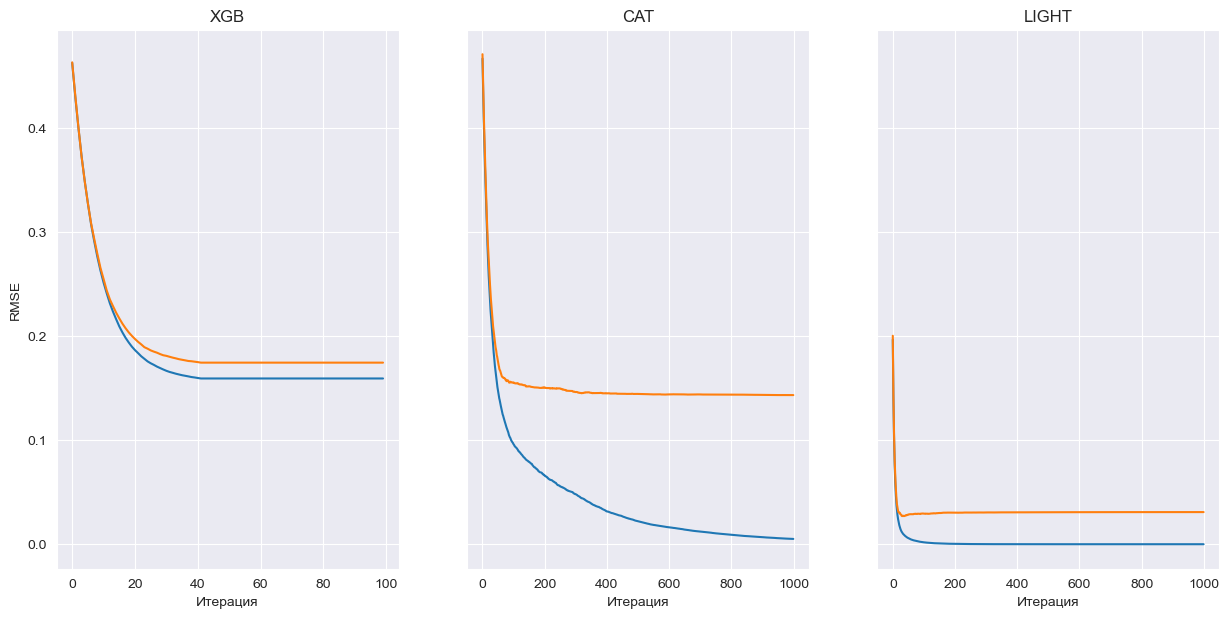

In [10]:
fig, ax = plt.subplots(figsize=(15,7), ncols=3, sharey=True)
ax[0].plot(np.arange(len(xg_reg_scores['validation_0']['rmse'])), xg_reg_scores['validation_0']['rmse'])
ax[0].plot(np.arange(len(xg_reg_scores['validation_1']['rmse'])), xg_reg_scores['validation_1']['rmse'])
ax[0].set_title('XGB')
ax[0].set_xlabel('Итерация')
ax[0].set_ylabel('RMSE')

ax[1].plot(np.arange(len(cat_reg_scores['validation_0']['RMSE'])), cat_reg_scores['validation_0']['RMSE'])
ax[1].plot(np.arange(len(cat_reg_scores['validation_1']['RMSE'])), cat_reg_scores['validation_1']['RMSE'])
ax[1].set_title('CAT')
ax[1].set_xlabel('Итерация')

ax[2].plot(np.arange(len(lgg_reg_scores['training']['l2'])), lgg_reg_scores['training']['l2'])
ax[2].plot(np.arange(len(lgg_reg_scores['valid_1']['l2'])), lgg_reg_scores['valid_1']['l2'])
ax[2].set_title('LIGHT')
ax[2].set_xlabel('Итерация')

plt.show()

**Вывод:**
На наивном бэйслайне лайтгбм моментально переобучился из-за безграничной глубины дерева (не получилось выставить ту же метрику, так что на графике lightGBM - $RMSE^2$).

Определите важность признаков используя Gini impurity и SHAP

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import shap

In [20]:
explainer_xgb = shap.Explainer(xg_reg)
shap_values_xgb = explainer_xgb(X)

explainer_cat = shap.Explainer(cat_reg)
shap_values_cat = explainer_cat(X)

explainer_lgg = shap.Explainer(lgg_reg)
shap_values_lgg = explainer_lgg(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


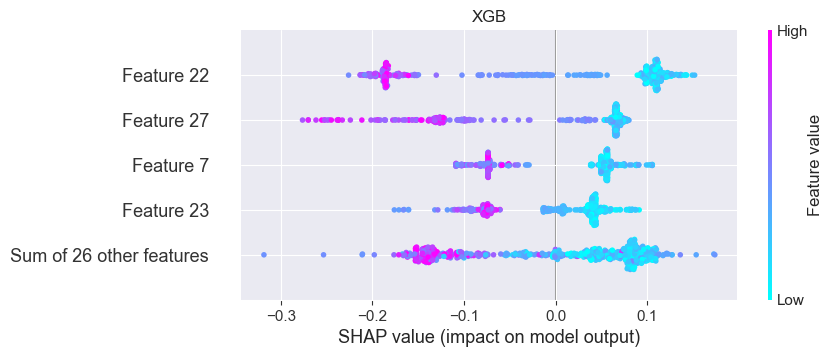

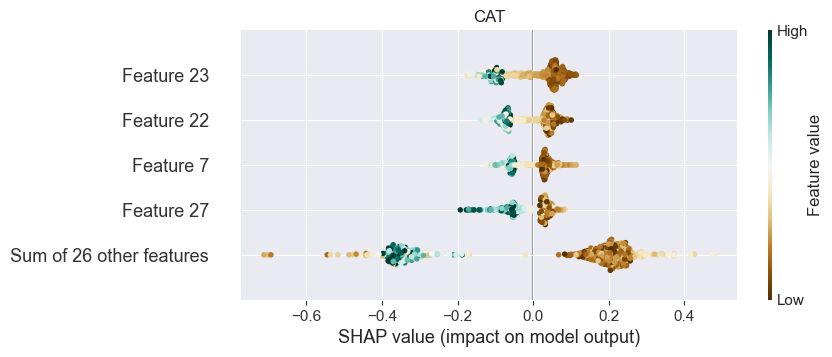

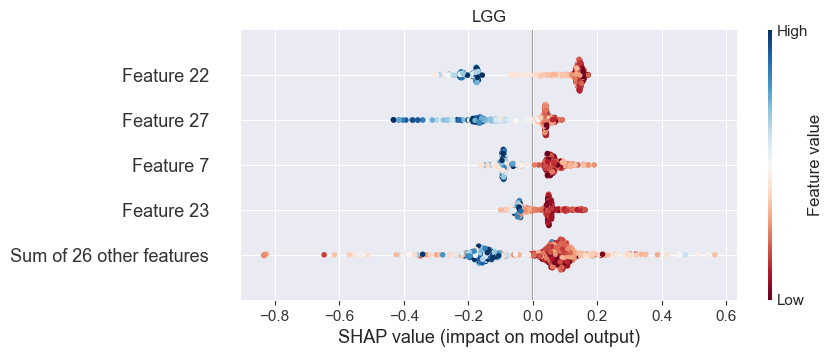

In [26]:
plt.title('XGB')
shap.plots.beeswarm(shap_values_xgb, color=plt.get_cmap("cool"), max_display=5)
plt.title('CAT')
shap.plots.beeswarm(shap_values_cat, color=plt.get_cmap("BrBG"), max_display=5)
plt.title('LGG')
shap.plots.beeswarm(shap_values_lgg, color=plt.get_cmap("RdBu"), max_display=5)

# Упражнение 2

В данном упражнении вам нужно будет оценить важность функциональный групп во взаимодействиях с заданным белком

Загрузите датасет

In [3]:
# !wget https://zenodo.org/record/3362353/files/activity_classes_ChEMBL24.dat?download=1
import urllib.request
urllib.request.urlretrieve("https://zenodo.org/record/3362353/files/activity_classes_ChEMBL24.dat?download=1", "activity_classes_ChEMBL24.dat")

('activity_classes_ChEMBL24.dat', <http.client.HTTPMessage at 0x2a678fb96d0>)

In [4]:
!cat 'activity_classes_ChEMBL24.dat?download=1'

"cat" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


Обработайте датасет и разделите его на тестовую выборку

In [2]:
activity_classes = []

with open('activity_classes_ChEMBL24.dat') as rf:
  for l in rf.readlines():
    line = [s.strip() for s in l.split('\t')]
    activity_classes.append(line)
import pandas as pd

df = pd.DataFrame(activity_classes)
df.columns = ['TargetID', 'TargetName', 'SMILES', 'AnalogSeriesID', 'pKi']
df = df.drop(df.index[0])
df

,TargetID,TargetName,SMILES,AnalogSeriesID,pKi
1,CHEMBL233,Mu opioid receptor,C#CCN1CCC23CCCCC2C1Cc4c3cc(cc4)O,1039,11.52
2,CHEMBL233,Mu opioid receptor,C#CCN1CN(C2(C1=O)CCN(CC2)C(c3ccccc3)c4ccccc4)c...,24317,5.37
3,CHEMBL233,Mu opioid receptor,CC(=NC(CO)C(=NCC1CC23CCC1(C4C25CCN(C3Cc6c5c(c(...,23111,8.23
4,CHEMBL233,Mu opioid receptor,CC(=NC(Cc1ccccc1)C(=NCC2CC34CCC2(C5C36CCN(C4Cc...,23111,9.44
5,CHEMBL233,Mu opioid receptor,CC(=O)CN1CN(C2(C1=O)CCN(CC2)C3CCC(c4c3cccc4)(C...,10988,7.85
...,...,...,...,...,...
5293,CHEMBL4792,Orexin receptor 2,c1ccc(c(c1)c2ncccn2)C(=O)N3C4CCC3C(C4)Nc5cnc(c...,6612,6.24
5294,CHEMBL4792,Orexin receptor 2,c1ccc(cc1)C2(CC2C(=O)Nc3ccccn3)COc4ccccc4,4774,6.01
5295,CHEMBL4792,Orexin receptor 2,c1ccc(cc1)CN2C(=O)CCCC23CCN(CC3)c4cnc5ccccc5n4,21610,6.51
5296,CHEMBL4792,Orexin receptor 2,c1ccc(cc1)CN2CCCC3(C2=O)CCN(CC3)c4[nH]c5ccccc5n4,15031,5.97


,TargetID,TargetName,SMILES,AnalogSeriesID,pKi
1,CHEMBL233,Mu opioid receptor,C#CCN1CCC23CCCCC2C1Cc4c3cc(cc4)O,1039,11.52
2,CHEMBL233,Mu opioid receptor,C#CCN1CN(C2(C1=O)CCN(CC2)C(c3ccccc3)c4ccccc4)c...,24317,5.37
3,CHEMBL233,Mu opioid receptor,CC(=NC(CO)C(=NCC1CC23CCC1(C4C25CCN(C3Cc6c5c(c(...,23111,8.23
4,CHEMBL233,Mu opioid receptor,CC(=NC(Cc1ccccc1)C(=NCC2CC34CCC2(C5C36CCN(C4Cc...,23111,9.44
5,CHEMBL233,Mu opioid receptor,CC(=O)CN1CN(C2(C1=O)CCN(CC2)C3CCC(c4c3cccc4)(C...,10988,7.85
...,...,...,...,...,...
5293,CHEMBL4792,Orexin receptor 2,c1ccc(c(c1)c2ncccn2)C(=O)N3C4CCC3C(C4)Nc5cnc(c...,6612,6.24
5294,CHEMBL4792,Orexin receptor 2,c1ccc(cc1)C2(CC2C(=O)Nc3ccccn3)COc4ccccc4,4774,6.01
5295,CHEMBL4792,Orexin receptor 2,c1ccc(cc1)CN2C(=O)CCCC23CCN(CC3)c4cnc5ccccc5n4,21610,6.51
5296,CHEMBL4792,Orexin receptor 2,c1ccc(cc1)CN2CCCC3(C2=O)CCN(CC3)c4[nH]c5ccccc5n4,15031,5.97


Установим rdkit, он вам пригодится.

In [3]:
import rdkit
from rdkit import Chem 
from rdkit.Chem import Descriptors

Вытянем из последовательностей смайлз признаки.

In [4]:
def get_mol_features(s):
  mol = Chem.MolFromSmiles(s)

  tpsa = Descriptors.TPSA(mol)
  logp = Descriptors.MolLogP(mol)
  wt = Descriptors.ExactMolWt(mol)
  ch = Descriptors.MaxPartialCharge(mol)
  rad_e = Descriptors.NumRadicalElectrons(mol)
  val_e = Descriptors.NumValenceElectrons(mol)
  h_acc = Descriptors.NumHAcceptors(mol)
  h_don = Descriptors.NumHDonors(mol)
  ar_r = Descriptors.NumAromaticRings(mol)
  bal = Descriptors.BalabanJ(mol)
  ipc = Descriptors.Ipc(mol)
  nhoh = Descriptors.NHOHCount(mol)
  no = Descriptors.NOCount(mol)
  hka = Descriptors.HallKierAlpha(mol)
  lab = Descriptors.LabuteASA(mol)
  csp = Descriptors.FractionCSP3(mol)
  return tpsa, logp, wt, ch, rad_e, val_e, h_acc, h_don, ar_r, bal, ipc, nhoh, no, hka, lab, csp

In [5]:
features = []
smiles = df['SMILES']

for s in smiles:
  features.append(get_mol_features(s))

data = pd.DataFrame(features)
data.columns = ['tpsa', 'logp', 'wt', 'ch', 'rad_e', 'val_e', 'h_acc', 'h_don', 'ar_r', 'bal', 'ipc', 'nhoh', 'no', 'hka', 'lab', 'csp']
data['pKi'] = df['pKi'].values.astype(float)
data['smiles'] = df['SMILES'].values

Посмотрите что у вас получилось в data

In [6]:
data.isna()

,tpsa,logp,wt,ch,rad_e,val_e,h_acc,h_don,ar_r,bal,ipc,nhoh,no,hka,lab,csp,pKi,smiles
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5292,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5293,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5294,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5295,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [9]:
from sklearn.preprocessing import StandardScaler

X, y = data.iloc[:, :-2], data['pKi']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)#Разделите выборку на обучение и тест

Выберите две модели, которые вам понравились из первого задания, обучите и проанализиуйте в SHAP

In [ ]:
# X_train[X_train.isna().max(axis=1)]
X_train.isna().min(axis=1)

In [14]:
cat_reg = catboost.CatBoostRegressor()
lgg_reg = lightgbm.LGBMRegressor()

In [18]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
  # Regression metrics
  explained_variance=metrics.explained_variance_score(y_true, y_pred)
  mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
  mse=metrics.mean_squared_error(y_true, y_pred)
  # mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
  median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
  r2=metrics.r2_score(y_true, y_pred)

  print('explained_variance: ', round(explained_variance,4))
  # print('mean_squared_log_error: ', round(mean_squared_log_error,4))
  print('r2: ', round(r2,4))
  print('MAE: ', round(mean_absolute_error,4))
  print('MSE: ', round(mse,4))
  print('RMSE: ', round(np.sqrt(mse),4))

LGG regression results:

explained_variance:  0.5092
r2:  0.5085
MAE:  0.6958
MSE:  0.8366
RMSE:  0.9147
LGG regression results:

explained_variance:  0.4917
r2:  0.49
MAE:  0.7083
MSE:  0.8681
RMSE:  0.9317


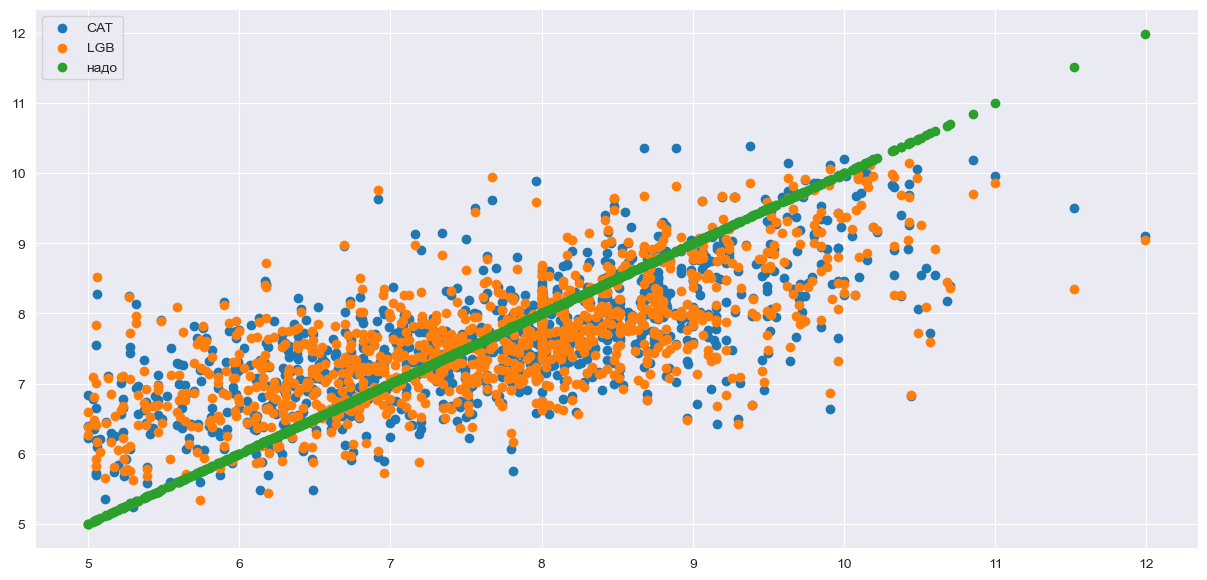

In [22]:
p_train = catboost.Pool(X_train, y_train)
p_test = catboost.Pool(X_test, y_test)
cat_reg.fit(
  p_train,
  verbose=False
)
y_pred_cat = cat_reg.predict(X_test)

lgg_reg.fit(
  X_train, y_train
)
y_pred_lgg = lgg_reg.predict(X_test)

print('LGG regression results:\n')
regression_results(y_test, y_pred_cat)
print('LGG regression results:\n')
regression_results(y_test, y_pred_lgg)

plt.figure(figsize=(15,7))
plt.scatter(y_test, y_pred_cat, label='CAT')
plt.scatter(y_test, y_pred_lgg, label='LGB')
plt.scatter(y_test, y_test, label = 'надо')
plt.legend()


## Зафиксируем резы на бэйслайне и начнем отпимизацию

In [23]:
import optuna
from optuna.samplers import TPESampler

In [ ]:
def objective(trial):
  model = catboost.CatBoostRegressor(
    iterations=trial.suggest_int("iterations", 500, 1200),
    depth=trial.suggest_int("depth", 4, 10),
    leaf_estimation_method = 'Newton',
    l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
    # bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
    grow_policy=trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise"]),
    random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
    bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
    # od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
    od_wait=100,
    verbose=False,
    task_type='CPU',
  )
  model.fit(p_train)
  y_pred = model.predict(X_test)
  return mean_squared_error(y_test, y_pred)

optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=120, show_progress_bar=True)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

best_cat_reg = catboost.CatBoostRegressor(**trial.params, verbose=False)
best_cat_reg.fit(p_train)
best_cat_reg.save_model('cat_best')
y_pred = best_cat_reg.predict(X_test)
regression_results(y_test, y_pred)

  0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
def objective(trial):
  model = lightgbm.LGBMRegressor(
    boosting_type=trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss"]),
    max_depth=trial.suggest_int("max_depth", -1, 12),
    n_estimators=trial.suggest_int("n_estimators", 300, 1200),
    reg_lambda=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
    task_type='CPU',
  )
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return mean_squared_error(y_test, y_pred)

optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
study_lgg = optuna.create_study(study_name="lightgbm", direction="minimize", sampler=sampler)
study_lgg.optimize(objective, n_trials=120, show_progress_bar=True)

print("Number of finished trials: ", len(study_lgg.trials))
print("Best trial:")
trial_lgg = study_lgg.best_trial
print("  Value: ", trial_lgg.value)
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

best_lgg_reg = lightgbm.LGBMRegressor(**trial_lgg.params, verbose=False)
best_lgg_reg.fit(X_train, y_train)
best_lgg_reg.save_model('lgg_best')
y_pred = best_cat_reg.predict(X_test)
regression_results(y_test, y_pred)

Сделайте выводы, есть ли разница между выбранными вами моделями. Какие параметры оказались важными.

Выводы

In [ ]:
X_train[X_train]